<a href="https://colab.research.google.com/github/mridulhalder/Springboard/blob/main/MiniProject_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape of the dataset (rows, columns): (32561, 15)

Number of NULL values in each column:
 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

First few rows with NULL values (if any):
 Empty DataFrame
Columns: [age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, income]
Index: []
AUC score for always predicting the majority class: 0.50
Number of columns after transformation: 108
AUC score of the model: 0.91


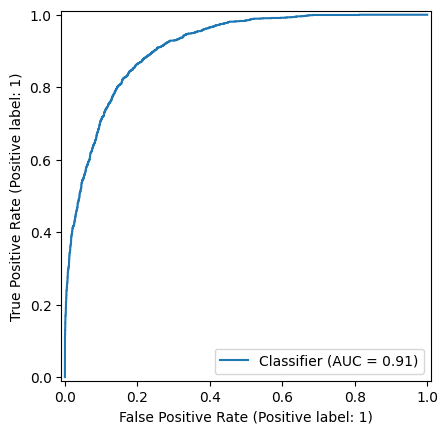

In [1]:


!pip install --upgrade scikit-learn scikeras

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from keras.layers import Input

DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Column names from the Adult dataset documentation
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load the dataset
df = pd.read_csv(DATA_PATH, header=None, names=columns, na_values=' ?', skipinitialspace=True)

# Display the first five rows
df.head()

# Encode the income column to binary (<=50K: 0, >50K: 1)
le = LabelEncoder()
df['income'] = le.fit_transform(df['income'])

# Exploratory analysis
print("Shape of the dataset (rows, columns):", df.shape)
print("\nNumber of NULL values in each column:\n", df.isnull().sum())
print("\nFirst few rows with NULL values (if any):\n", df[df.isnull().any(axis=1)].head())

# Split features and target
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Find the majority class in the training set
majority_class = y_train.mode()[0]

# Predict the majority class for all test samples
y_pred_majority = np.full_like(y_test, fill_value=majority_class)

# Calculate the AUC score for this naive method
auc_majority = roc_auc_score(y_test, y_pred_majority)
print(f"AUC score for always predicting the majority class: {auc_majority:.2f}")


categorical_cols = [
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "sex", "native-country"
]
continuous_cols = [
    "age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"
]

# Set up the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('cont', MinMaxScaler(), continuous_cols)
    ]
)

# Fit and transform the features (excluding the target)
X_processed = preprocessor.fit_transform(df.drop('income', axis=1))

# Show the resulting shape (number of columns after transformation)
print("Number of columns after transformation:", X_processed.shape[1])

# Define the Keras model
def create_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

# Create a Keras classifier
keras_clf = KerasClassifier(
    model=create_model,
    model__input_dim=X_processed.shape[1],
    epochs=10,
    batch_size=32,
    verbose=0
)

# Create the scikit-learn pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', keras_clf)
])

pipeline.fit(X_train, y_train)

# Predict probabilities for the test data
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate the AUC score of your model on the test data
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC score of the model: {auc_score:.2f}")

# Generate an ROC curve for your model
RocCurveDisplay.from_predictions(y_test, y_pred_proba)